In [7]:
import tifffile
import pandas
from griottes import generate_contact_graph, generate_delaunay_graph, generate_geometric_graph, plot_2D

import urllib3
import shutil
import os

import matplotlib.pyplot as plt
import seaborn as sns

# Load image and mask of nuclei

First download the image from the latest release of `Griottes`.

In [ ]:
url = 'https://github.com/BaroudLab/Griottes/releases/download/v1.0-alpha/zebrafish_brain_cell_labels.tiff'
filename = 'zebrafish_brain_cell_labels.tiff'

if not os.path.exists(filename):
    c = urllib3.PoolManager()

    with c.request('GET',url, preload_content=False) as resp, open(filename, 'wb') as out_file:
        shutil.copyfileobj(resp, out_file)

    resp.release_conn()
else:
    print('dataset already exists')

We then load the image to generate the different graphs from it.

In [ ]:
image = tifffile.imread(filename)
image.shape

# Generating a contact graph

From the masks of the complete cells we can build the contact graph of the network, connecting together cells sharing a common border.

In [ ]:
G_contact = generate_contact_graph(image[..., 4],
                                                 analyze_fluo_channels=False, 
                                                 radius = 100)

In [ ]:
G_geometric = generate_geometric_graph(image[..., 4],
                                                 analyze_fluo_channels=False,
                                                 image_is_2D = True,
                                                 distance=75)

In [ ]:
G_delaunay = generate_delaunay_graph(image[..., 4],
                                                 analyze_fluo_channels=False,
                                                 image_is_2D = True,
                                                 distance=75)

## Plotting a representation of the graph

From the graph `G` it is possible to plot a visual representation of the network. NetworkX has several plotting functions available for representing graphs, however `Griottes` contains several specific plotting functions adapted for the network representation of tisssues. These functions are called through the `graph_plot` module.

In [ ]:
plot_2D(G_geometric,
                background_image=image[...,1],
                figsize = (5,5),
                alpha_line = 1,
                scatterpoint_size = 18,
                edge_color = 'w',
                line_factor = 1)

plot_2D(G_delaunay,
                background_image=image[...,1],
                figsize = (5,5),
                alpha_line = 1,
                scatterpoint_size = 18,
                edge_color = 'w',
                line_factor = 1)

Adding the `background_image` variable allows to plot the network on to the tissue image of your choice. Here we do it with the contact graph:

In [ ]:
plot_2D(G_contact,
                background_image = image[:, :,1],
                figsize = (5,5),
                alpha_line = .5,
                scatterpoint_size = 10,
                legend = True,
                edge_color = 'w',
                line_factor = 0.15)

# Estimating the properties of the generated graphs

From the individual graphs we can then compute different statistics recapitulated in Figure 2. We use the methods of the `NetworkX` library to access relevant properties of individual nodes/cells in the tissue.

In [9]:
url = 'https://github.com/BaroudLab/Griottes/releases/download/v1.0-alpha/zebrafish_brain_cell_labels_whole_cut.tiff'
filename = 'zebrafish_brain_cell_labels_whole_cut.tiff'

if not os.path.exists(filename):
    c = urllib3.PoolManager()

    with c.request('GET',url, preload_content=False) as resp, open(filename, 'wb') as out_file:
        shutil.copyfileobj(resp, out_file)

    resp.release_conn()
else:
    print('dataset already exists')

In [10]:
image = tifffile.imread(filename)

descriptors = ['label', 'x', 'y']

G_contact = generate_contact_graph(image[..., 4],
                                   descriptors = descriptors,
                                   analyze_fluo_channels=False, 
                                   radius = 100)

G_geometric = generate_geometric_graph(image[..., 4],
                                   descriptors = descriptors,
                                   analyze_fluo_channels=False, 
                                   radius = 100)

G_delaunay = generate_delaunay_graph(image[..., 4],
                                   descriptors = descriptors,
                                   analyze_fluo_channels=False, 
                                   radius = 100)

The input image has 2 dimensions, it will be analyzed as a labeled image.
The input image has 2 dimensions, it will be analyzed as a labeled image.
The input image has 2 dimensions, it will be analyzed as a labeled image.


For instance, we can compare the different neighborhoods generated for each cell as a function of the network construction method. Cell by cell we compare the degrees, using the contact-based properties as a ground truth: 

In [11]:
degree_array = pandas.DataFrame()
j = 0

for node in G_contact.nodes():
    
    label = G_contact.nodes[node]['label']
    
    if label > 0:
    
        node_in_geometric_graph = [i for i in G_geometric.nodes() if G_geometric.nodes[i]['label'] == label][0]
        node_in_delaunay_graph = [i for i in G_delaunay.nodes() if G_delaunay.nodes[i]['label'] == label][0]

        degree_array.loc[j, 'node'] = node
        degree_array.loc[j, 'label'] = label
        degree_array.loc[j, 'degree_contact'] = G_contact.degree[node]
        degree_array.loc[j, 'degree_geometric'] = G_geometric.degree[node_in_geometric_graph]
        degree_array.loc[j, 'degree_voronoi'] = G_delaunay.degree[node_in_delaunay_graph]

        j += 1

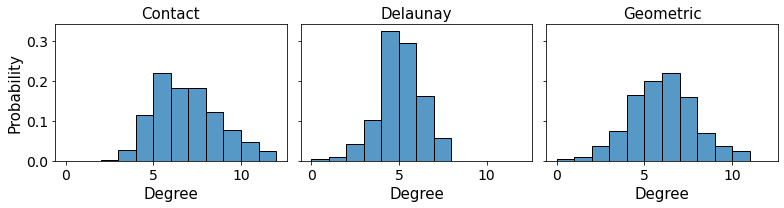

In [12]:
fig, ax = plt.subplots(1,3,figsize = (11,3), sharex = True, sharey = True)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[2].tick_params(axis='both', which='minor', labelsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=14)

ax[0] = sns.histplot(data = degree_array,
             x = 'degree_contact',
             binwidth = 1,
             ax = ax[0], kde=False, stat = 'probability')

ax[1] = sns.histplot(data = degree_array,
             x = 'degree_voronoi',
             binwidth = 1,
             ax = ax[1], kde=False, stat = 'probability')

ax[2] = sns.histplot(data = degree_array,
             x = 'degree_geometric',
             binwidth = 1,
             ax = ax[2], kde=False, stat = 'probability')

ax[0].set_ylabel('Probability', fontsize = 15)

ax[0].set_xlabel('Degree', fontsize = 15)
ax[1].set_xlabel('Degree', fontsize = 15)
ax[2].set_xlabel('Degree', fontsize = 15)

ax[0].set_title('Contact', fontsize = 15)
ax[1].set_title('Delaunay', fontsize = 15)
ax[2].set_title('Geometric', fontsize = 15)

plt.tight_layout()

The importance of cell-cell contacts ("weights") are contained within the contact-based graph generated by the `generate_contact_graph` method. We can access all the individual weights using `NetworkX` and plot the distribution of cell-cell contacts in the tissue:

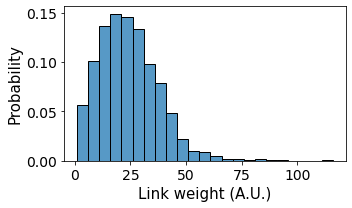

In [13]:
weight_frame = pandas.DataFrame()
i = 0

for u,v,a in G_contact.edges(data=True):
    
    weight_frame.loc[i, 'weight'] = a['weight']
    i += 1
    
fig, ax = plt.subplots(1,1,figsize = (5,3), sharex = True, sharey = True)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

ax = sns.histplot(data = weight_frame,
             x = 'weight',
             binwidth = 5,
             ax = ax, kde=False, stat = 'probability')

ax.set_ylabel('Probability', fontsize = 15)
ax.set_xlabel('Link weight (A.U.)', fontsize = 15)

plt.tight_layout()